In [1]:
import lightgbm as lgb
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
raw = pd.read_csv("data.csv")
raw.head()

,순번,H,S,V,R,G,B,l,a,b,계절,봄,여름,가을,겨울,CW
0,1,7,11,84,215,194,191,80,7,4,1,1,0,0,0,1
1,2,354,50,85,218,108,119,59,45,15,1,1,0,0,0,1
2,3,11,65,85,218,103,76,58,45,38,1,1,0,0,0,1
3,4,1,65,82,210,76,73,52,54,32,1,1,0,0,0,1
4,5,36,79,83,211,143,44,65,21,60,1,1,0,0,0,1


In [73]:
X = raw[['H','S', 'V', 'R', 'G', 'B']]
y = raw[['CW']]

X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

In [86]:
params = {
    'learning_rate': 0.01, 
    'max_depth': 15, 
    'boosting': 'gbdt', 
    'objective': 'regression', 
    'metric': 'mse', 
    'is_training_metric': True, 
    'num_leaves': 144, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.7, 
    'bagging_freq': 5, 
    'seed':2018
}

model = lgb.train(params,
                  lgb_train,
                  3000,
                  lgb_test,
                  verbose_eval=100,
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.164855
[200]	valid_0's l2: 0.144559
[300]	valid_0's l2: 0.138322
[400]	valid_0's l2: 0.138929
Early stopping, best iteration is:
[310]	valid_0's l2: 0.137552


In [87]:
predict_train = model.predict(X_train)
#print(predict_train)

predict_test = model.predict(X_test)
#print(predict_test)

In [88]:
mse = mean_squared_error(y_test, predict_test)
print('Mean squared error: ', mse)

r2 = r2_score(y_test, predict_test)
print('R2 score: ', r2)

Mean squared error:  0.1375517282358845
R2 score:  0.449181066018705


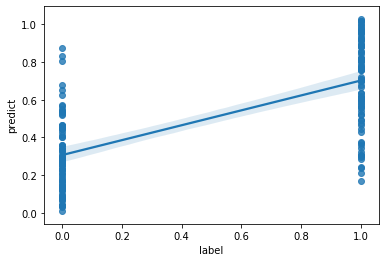

In [89]:
final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)
final_result.columns = ['label','predict']
sns.regplot(x = 'label', y = 'predict', data = final_result)

In [90]:
Y_predict = model.predict(X_test)
#print(Y_predict)

In [91]:
model_matrix = metrics.confusion_matrix(y_test, Y_predict.round())
print(model_matrix)

model_report = metrics.classification_report(y_test, Y_predict.round())
print(model_report)

[[73 14]
 [20 73]]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        87
           1       0.84      0.78      0.81        93

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.81      0.81      0.81       180



<h1><hr></h1>

In [10]:
#from bayesian-optimization import BayesianOptimization
from bayes_opt import BayesianOptimization

In [31]:
def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def lgb_f1_score(y_hat, data):
    y_true = data.get_label().astype(int)
    y_hat = np.round(y_hat).astype(int) # scikits f1 doesn't like probabilities
    return 'f1', lgb_f1_score(y_true, y_hat), True

In [37]:
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {'application':'binary',
              'num_iterations': 500 , 
              'learning_rate':0.05, 
              'early_stopping_round':100,
              "objective" : "binary",
              "num_threads" : 20 ,
             }
    
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    cv_result = lgb.cv(params, lgb_train,
                       nfold=n_folds, seed=random_seed, 
                       stratified=True, verbose_eval =200, 
                       metrics=["None"], 
                      # feval=lgb_f1_score
                      )
    
    return max(cv_result['f1-mean'])

In [38]:
model_BO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 8.99),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}, random_state=0)

In [39]:
init_round=5
opt_round = 10
n_folds = 5
random_seed=6

In [40]:
model_BO.maximize(init_points=init_round, n_iter=opt_round)
model_BO.points_to_csv("data.csv")

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


C:\Users\hande\Anaconda3\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\hande\Anaconda3\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

In [36]:
params = model_BO.res['max']['max_params']

lgb2 = lgb.train(params, train_X , 100)
#lgb2 = lgb.train(params, d_train, 100)
lgb_prob = lgb2.predict( lgb_test.values )

TypeError: list indices must be integers or slices, not str